# Simulating a Tandem Queue of 2 M/M/1 Queueing System with Python and SimPy

## Author: Fernando A. Acosta-Perez

### Overview
This notebook demonstrates the simulation of tandem queue queueing system using the SimPy library in Python. The simulation evaluates key metrics such as average waiting time and average queue size, providing insights into the system's performance under specific arrival and service rates.

---


## Import libraries

In [1]:
import simpy
import random
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

## Build Simulation

In [42]:
import simpy
import random
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde


class MonitoredResource(simpy.Resource):
    """
    Extends simpy.Resource to log queue lengths and timestamps at requests and releases.
    """
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.data = []  # To store queue length and timestamp

    def request(self, *args, **kwargs):
        self.data.append((self._env.now, len(self.queue)))  # Log queue length at request
        return super().request(*args, **kwargs)

    def release(self, *args, **kwargs):
        self.data.append((self._env.now, len(self.queue)))  # Log queue length at release
        return super().release(*args, **kwargs)


class TandemMM1QueueSimulation:
    """
    Encapsulates the M/M/1 queue simulation using SimPy.
    """

    def __init__(self, simulation_time, interarrival_rate, service_rate1, service_rate2, num_servers1, num_servers2, verbose=True):
        self.simulation_time = simulation_time
        self.interarrival_rate = interarrival_rate
        self.service_rate1 = service_rate1
        self.service_rate2 = service_rate2
        self.num_servers1 = num_servers1
        self.num_servers2 = num_servers2
        self.verbose = verbose

        # Create environment and monitored resources
        self.env = simpy.Environment()
        self.server1 = MonitoredResource(self.env, capacity=self.num_servers1)
        self.server2 = MonitoredResource(self.env, capacity=self.num_servers2)

        # Lists to store metrics
        self.wait_times_server1 = []  # Waiting times for Server 1
        self.wait_times_server2 = []  # Waiting times for Server 2

    def log(self, message):
        """Prints a message if verbose mode is enabled."""
        if self.verbose:
            print(message)

    def customer_process(self, name, arrival_time):
        """
        Simulates a single customer’s journey through the system.
        """
        self.log(f"{name} arrives at {self.env.now:.2f}")

        # Request Server 1 and wait for availability
        request1 = self.server1.request()
        yield request1

        # Once available, start server 1 process
        self.log(f"{name} starts service at Server 1 at {self.env.now:.2f}")
        wait_time1 = self.env.now - arrival_time
        self.wait_times_server1.append(wait_time1)

        # Simulate service time at Server 1
        service_time1 = random.expovariate(self.service_rate1)
        yield self.env.timeout(service_time1)

        # Once server1 is done, you need to request server 2, and wait without releasing server 1
        self.log(f"{name} finishes service at Server 1 at {self.env.now:.2f}, and now waits for Server 2")
        server1_completion_time = self.env.now  # Time stamp when service completes in Server 1

        # Request Server 2 (blocking occurs here if Server 2 is full)
        with self.server2.request() as request2:
            yield request2  # Wait until Server 2 is available

            # Once available, release customer from Server 1 and start process in Server 2
            self.log(f"{name} starts service at Server 2 at {self.env.now:.2f}")
            yield self.server1.release(request1)

            # Store wait time metrics
            wait_time2 = self.env.now - server1_completion_time
            self.wait_times_server2.append(wait_time2)

            # Simulate service time at Server 2
            service_time2 = random.expovariate(self.service_rate2)
            yield self.env.timeout(service_time2)

            self.log(f"{name} finishes service at Server 2 and exits at {self.env.now:.2f}")

    def customer_arrivals(self):
        """Simulates the arrival of customers based on an exponential interarrival time."""
        customer_count = 0
        while True:
            interarrival_time = random.expovariate(self.interarrival_rate)
            yield self.env.timeout(interarrival_time)

            customer_count += 1
            self.env.process(self.customer_process(f"Customer {customer_count}", self.env.now))

    def run(self):
        """Runs the simulation."""
        # Start the customer arrival process
        self.env.process(self.customer_arrivals())

        # Run the simulation
        self.env.run(until=self.simulation_time)

        # Log the final queue sizes
        final_queue_size1 = len(self.server1.queue)
        final_queue_size2 = len(self.server2.queue)
        self.server1.data.append((self.simulation_time, final_queue_size1))
        self.server2.data.append((self.simulation_time, final_queue_size2))

    def compute_metrics(self):
        """Computes and displays key metrics from the simulation for both Server 1 and Server 2."""
        # Average waiting times
        avg_wait_time1 = np.mean(self.wait_times_server1) if self.wait_times_server1 else 0
        avg_wait_time2 = np.mean(self.wait_times_server2) if self.wait_times_server2 else 0

        # Average queue sizes
        avg_queue_size1 = self._compute_avg_queue_size(self.server1.data, self.simulation_time)
        avg_queue_size2 = self._compute_avg_queue_size(self.server2.data, self.simulation_time)

        # Display metrics
        print(f"\nAverage waiting time (Server 1): {avg_wait_time1:.2f} time units")
        print(f"Average waiting time (Server 2): {avg_wait_time2:.2f} time units")
        print(f"Average queue size (Server 1): {avg_queue_size1:.2f}")
        print(f"Average queue size (Server 2): {avg_queue_size2:.2f}")

    def _compute_avg_queue_size(self, queue_data, simulation_time):
        """Computes the time-weighted average queue size for a server."""
        if len(queue_data) == 0:
            return 0
        queue_data = np.array(queue_data)
        event_times = queue_data[:, 0]
        queue_sizes = queue_data[:, 1]

        time_intervals = np.diff(np.append(0, event_times))
        return np.sum(queue_sizes * time_intervals) / simulation_time

    def plot_queue(self, server_name, server_data):
        """Plots the queue size over time for the given server."""
        queue_data = np.array(server_data)
        env_time = queue_data[:, 0]
        queue_sizes = queue_data[:, 1]

        plt.figure()
        plt.step(env_time, queue_sizes, where='post')
        plt.xlabel('Environment Time')
        plt.ylabel('Queue Size')
        plt.title(f'Queue Size Over Time ({server_name})')
        plt.grid(True)
        plt.show()

    def plot_waiting_time_density(self, server_name, wait_times):
        """Plots the density of waiting times for the given server."""
        if len(wait_times) == 0:
            print(f"No waiting times recorded for {server_name}; cannot plot density.")
            return

        kde = gaussian_kde(wait_times)
        x_vals = np.linspace(min(wait_times), max(wait_times), 500)
        y_vals = kde(x_vals)

        plt.figure()
        plt.plot(x_vals, y_vals, label=f"{server_name} Waiting Time Density")
        plt.xlabel('Waiting Time')
        plt.ylabel('Density')
        plt.title(f'Density of Waiting Times ({server_name})')
        plt.grid(True)
        plt.legend()
        plt.show()

## Execution

Customer 1 arrives at 0.22
Customer 1 starts service at Server 1 at 0.22
Customer 1 finishes service at Server 1 at 0.26, and now waits for Server 2
Customer 1 starts service at Server 2 at 0.26
Customer 2 arrives at 0.66
Customer 2 starts service at Server 1 at 0.66
Customer 2 finishes service at Server 1 at 0.68, and now waits for Server 2
Customer 3 arrives at 0.94
Customer 4 arrives at 1.00
Customer 5 arrives at 1.00
Customer 6 arrives at 1.59
Customer 7 arrives at 1.79
Customer 8 arrives at 2.27
Customer 9 arrives at 2.27
Customer 10 arrives at 2.43
Customer 11 arrives at 2.55
Customer 12 arrives at 2.64
Customer 13 arrives at 3.03
Customer 14 arrives at 3.13
Customer 15 arrives at 3.19
Customer 16 arrives at 3.20
Customer 17 arrives at 3.49
Customer 18 arrives at 3.55
Customer 1 finishes service at Server 2 and exits at 3.60
Customer 2 starts service at Server 2 at 3.60
Customer 3 starts service at Server 1 at 3.60
Customer 3 finishes service at Server 1 at 3.72, and now waits fo

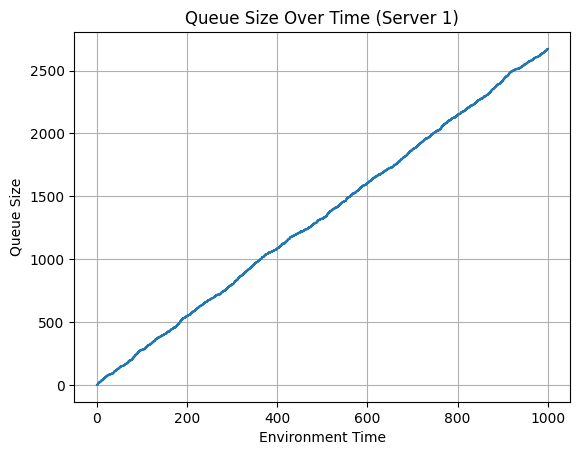

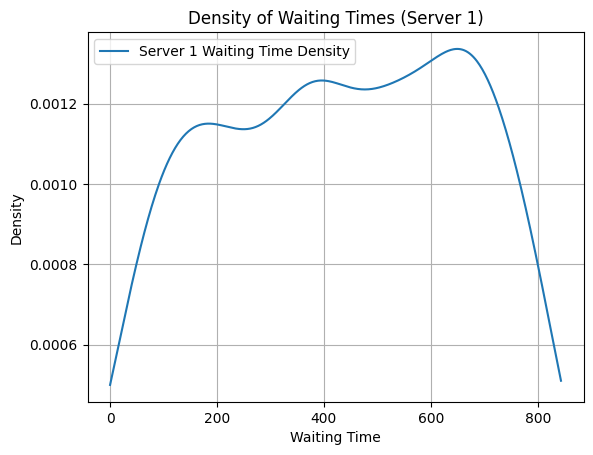

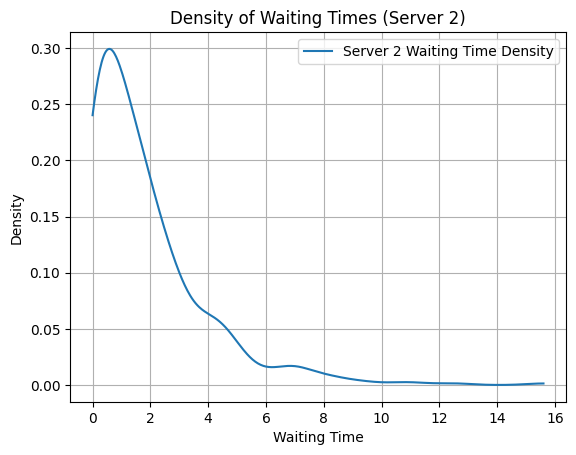

In [65]:
if __name__ == "__main__":
    # Simulation parameters
    SIMULATION_TIME = 1000         # Total simulation time
    INTERARRIVAL_RATE = 3        # Arrival rate (λ)
    SERVICE_RATE1 = 4            # Service rate for Server 1 (μ1)
    SERVICE_RATE2 = 0.50            # Service rate for Server 2 (μ2)
    NUM_SERVERS1 = 1               # Number of servers in Server 1
    NUM_SERVERS2 = 1               # Number of servers in Server 2
    VERBOSE = True                 # Toggle for detailed logs

    # Create and run simulation
    simulation = TandemMM1QueueSimulation(
        simulation_time=SIMULATION_TIME,
        interarrival_rate=INTERARRIVAL_RATE,
        service_rate1=SERVICE_RATE1,
        service_rate2=SERVICE_RATE2,
        num_servers1=NUM_SERVERS1,
        num_servers2=NUM_SERVERS2,
        verbose=VERBOSE
    )
    simulation.run()
    simulation.compute_metrics()

    # Plot metrics
    simulation.plot_queue("Server 1", simulation.server1.data)
    simulation.plot_waiting_time_density("Server 1", simulation.wait_times_server1)
    simulation.plot_waiting_time_density("Server 2", simulation.wait_times_server2)